# Time Series Forecasting with TensorFlow

### Contents of this notebook
  * Get the time series data
    * Load the time series data using Pandas/Python,s CSV module
  * Format data for a time series problem
    * Creating training and test sets (the wrong way)
    * Creating training and test sets (the right way)
    * Visualizing time series data
    * Turning time series data into a supervised learning problem (windowing)
    * Preparing univariate and multivariate
  * Evaluating a time series forecasting model
  * Setting up a series of deep learning modelling experiments
    * Dense (fully-connected) networks
    * Sequence models (LSTM and 1D CNN)
    * Ensembling (combining multiple models together)
    * Multivariate models
    * Replicating the N-BEATS algorithm using TensorFlow layer subclassing
  * Creating a model checkpoint to save the best performing model during training
  * Making predictions (forecasts) with a time series model
  * Creating prediction intervals for the time series model forecasts
  * Discussing two different types of uncertainity in machine learning (data uncertainity and model uncertainity)
  * Demonstrating why forecasting in an open system is BS (the turkey problem)

### Check for GPU

In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-29d81a66-7a9e-7e55-c914-d794db2f3a9a)


## Get data

In [2]:
# Download Bitcoin historical data from GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-02-26 18:10:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2023-02-26 18:10:19 (7.66 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



### Importing time series data with pandas

In [3]:
# Import with pandas
import pandas as pd
import numpy as np
df = pd.read_csv('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                 parse_dates=['Date'],
                 index_col=['Date'])

In [4]:
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [6]:
df.shape

(2787, 5)

In [7]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)': 'Price'})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


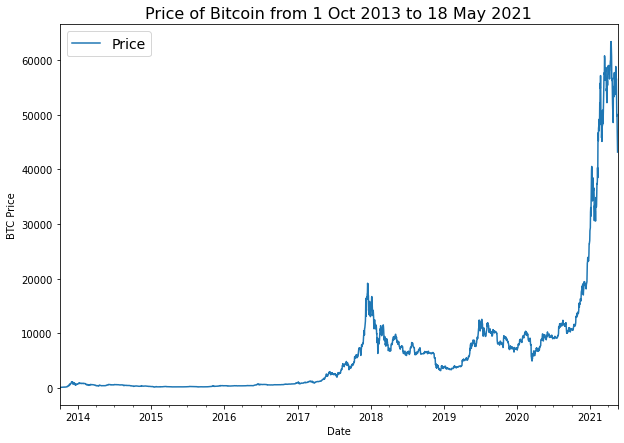

In [8]:
# Visulaizing data
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 1 Oct 2013 to 18 May 2021', fontsize=16)
plt.legend(fontsize=14)

### Importing time series data with Python's CSV module

In [9]:
# Importing and formatting historical Bitcoin data with Python

import csv
from datetime import datetime

timesteps = []
btc_price = []
with open('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv') as f:
  csv_reader = csv.reader(f, delimiter=',')
  next(csv_reader)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))
    btc_price.append(float(line[2]))

# View first 10 of each

timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0.5, 0, 'Date')

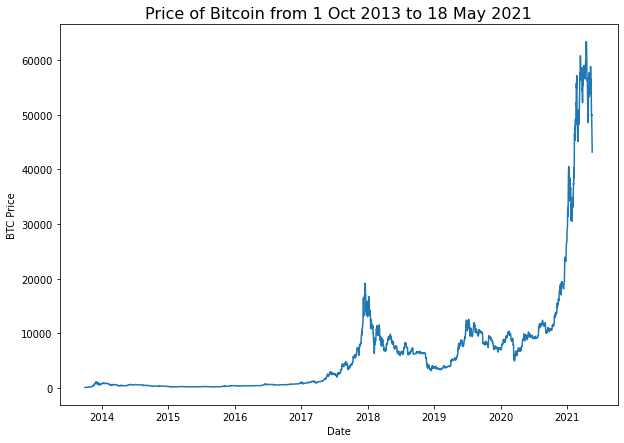

In [10]:
# Plot from CSV
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 1 Oct 2013 to 18 May 2021', fontsize=16)
plt.xlabel('Date')

## Formatting data for time series problem

### Creating train and test sets for time series data (the wrong way)

In [11]:
# Get Bitcoin date array

timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [12]:
# Wrong way to make train test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

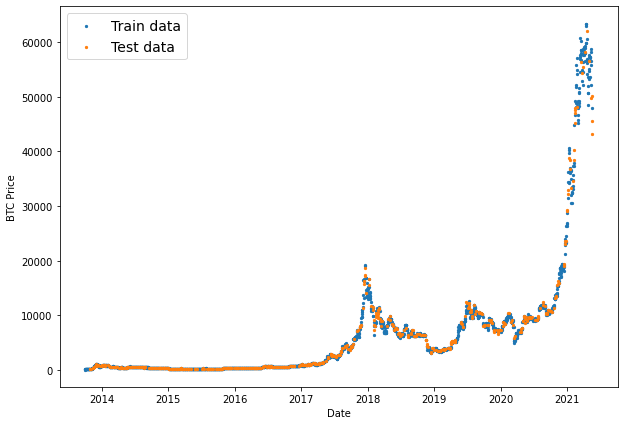

In [13]:
# Plotting wrong train and test splits

plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show()

### Creating train and test sets for time series data (the right way)

In [14]:
split_size = int(0.8 * len(prices))

X_train, y_train = timesteps[0:split_size], prices[:split_size]

X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

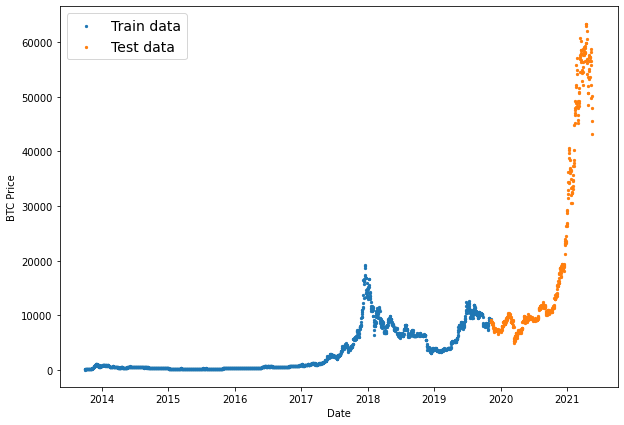

In [15]:
# Plot correctly made splits

plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show()

### Creating a plotting function

In [16]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel('BTC Price')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True) 

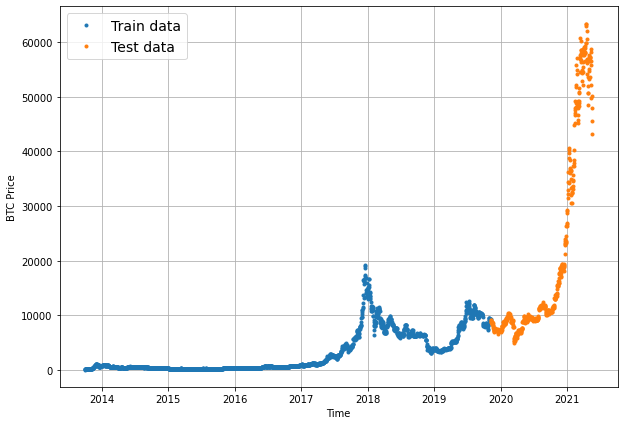

In [17]:
# Try out our plotting function

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')

## Modelling Experiments

### Model 0: Naive Forecast (baseline)

In [18]:
# Create a naive forecast

naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

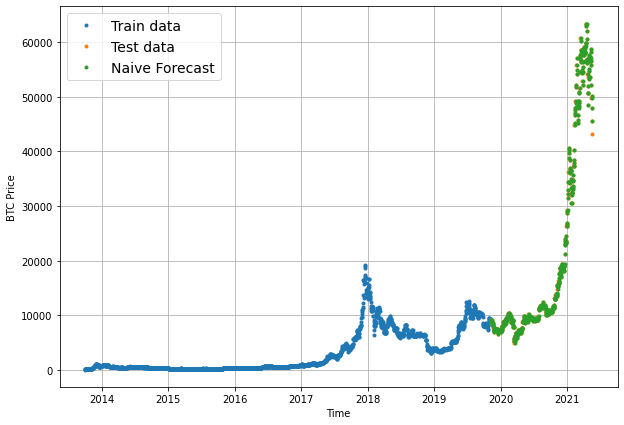

In [19]:
# Plot naive forecast

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, label='Naive Forecast')

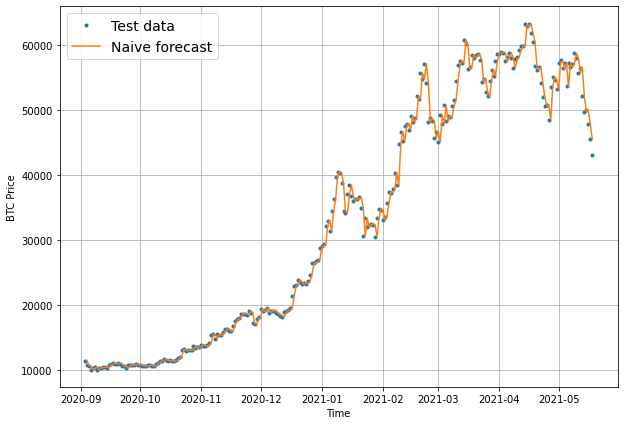

In [20]:
# Zooming in the plot

plt.figure(figsize=(10, 7))
offset = 300
plot_time_series(timesteps=X_test, values=y_test, start=offset, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=offset, format='-', label='Naive forecast')


### Evaluating a time series model

In [21]:
import tensorflow as tf

In [22]:
# Create a function to calculate MASE (mean absolute scaled error)

def mean_absolute_scaled_error(y_true, y_pred):
  
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))
  
  return mae/mae_naive_no_season

In [23]:
# Create a function to calculate results (predictions)

def evaluate_preds(y_true, y_pred):

  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [24]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

### Other models/libraries for time series forecasting
  * Moving average
  * ARIMA (AutoRegression Integrated Moving Average)
  * Sktime (Scikit-learn for time series)
  * TensorFlow Decision Forecasts (random forest, gradient boosting trees)
  * Facebook Kats (purpose built forecasting and time series analysis library by facebook)
  * LinkedIn Greykite (flexible, intuitive and fast forecasts)


### Windowing dataset

In [25]:
HORIZON = 1           # Predict 1 step at a time
WINDOW_SIZE = 7       # Use a week worth of timestamps to predict the horizon

In [26]:
# Create a function to label windowed data

def get_labelled_windows(x, horizon=1):

  return x[:,:-horizon], x[:,-horizon:]

In [27]:
# Test out the window labelling function

test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {test_window} -> Label: {test_label}")

Window: [[1 2 3 4 5 6 7]] -> Label: [[8]]


In [28]:
# Create a function to view NumPy arrays as windows

def make_windows(x, window_size=7, horizon=1):

  # 1. Create a window of specific window size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for zero indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)), axis=0).T

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [29]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [30]:
# View the first three windows/labels

for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


### Turning windows into training and test sets

In [31]:
# Make the train test split

def make_train_test_split(windows, labels, test_split=0.2):

  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [32]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [33]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

### Make modelling checkpoint

In [34]:
import os

# Create a function ti implement model checkpoint callback with a specific filename

def create_model_checkpoint(model_name, save_path="model_experiments"):
  
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

### Model 1: Dense model (window = 7, horizon = 1)

In [35]:
import tensorflow as tf
from tensorflow.keras import layers

# Set seed
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

# Fit model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
13/18 [====================>.........] - ETA: 0s - loss: 700.9844 - mae: 700.9844    

18/18 [==============================] - 8s 89ms/step - loss: 616.1766 - mae: 616.1766 - val_loss: 1124.7377 - val_mae: 1124.7377
Epoch 2/100
12/18 [===================>..........] - ETA: 0s - loss: 239.3627 - mae: 239.3627

18/18 [==============================] - 1s 34ms/step - loss: 234.9995 - mae: 234.9995 - val_loss: 1096.9310 - val_mae: 1096.9310
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 191.0404 - mae: 191.0404 - val_loss: 1194.2158 - val_mae: 1194.2158
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 241.8531 - mae: 241.8531

18/18 [==============================] - 0s 28ms/step - loss: 180.6357 - mae: 180.6357 - val_loss: 973.2617 - val_mae: 973.2617
Epoch 5/100
18/18 [==============================] - ETA: 0s - loss: 169.4942 - mae: 169.4942

18/18 [==============================] - 0s 29ms/step - loss: 169.4942 - mae: 169.4942 - val_loss: 922.2393 - val_mae: 922.2393
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 163.4746 - mae: 163.4746 - val_loss: 983.7720 - val_mae: 983.7720
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 216.1888 - mae: 216.1888

18/18 [==============================] - 0s 27ms/step - loss: 156.0038 - mae: 156.0038 - val_loss: 838.3767 - val_mae: 838.3767
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 115.9523 - mae: 115.9523

18/18 [==============================] - 1s 32ms/step - loss: 149.9482 - mae: 149.9482 - val_loss: 837.4706 - val_mae: 837.4706
Epoch 9/100
15/18 [========================>.....] - ETA: 0s - loss: 155.5847 - mae: 155.5847

18/18 [==============================] - 1s 41ms/step - loss: 154.6142 - mae: 154.6142 - val_loss: 792.3362 - val_mae: 792.3362
Epoch 10/100
16/18 [=========================>....] - ETA: 0s - loss: 145.4584 - mae: 145.4584

18/18 [==============================] - 1s 51ms/step - loss: 147.2586 - mae: 147.2586 - val_loss: 775.2368 - val_mae: 775.2368
Epoch 11/100
15/18 [========================>.....] - ETA: 0s - loss: 141.9245 - mae: 141.9245

18/18 [==============================] - 1s 48ms/step - loss: 139.9225 - mae: 139.9225 - val_loss: 772.3043 - val_mae: 772.3043
Epoch 12/100
18/18 [==============================] - 0s 5ms/step - loss: 135.3897 - mae: 135.3897 - val_loss: 837.2587 - val_mae: 837.2587
Epoch 13/100
13/18 [====================>.........] - ETA: 0s - loss: 137.2448 - mae: 137.2448

18/18 [==============================] - 1s 36ms/step - loss: 140.5669 - mae: 140.5669 - val_loss: 753.6125 - val_mae: 753.6125
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 126.9490 - mae: 126.9490

18/18 [==============================] - 1s 61ms/step - loss: 135.5698 - mae: 135.5698 - val_loss: 725.5245 - val_mae: 725.5245
Epoch 15/100
12/18 [===================>..........] - ETA: 0s - loss: 134.0769 - mae: 134.0769

18/18 [==============================] - 1s 55ms/step - loss: 139.0439 - mae: 139.0439 - val_loss: 717.0986 - val_mae: 717.0986
Epoch 16/100
13/18 [====================>.........] - ETA: 0s - loss: 129.8776 - mae: 129.8776

18/18 [==============================] - 1s 37ms/step - loss: 127.7145 - mae: 127.7145 - val_loss: 702.1080 - val_mae: 702.1080
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 110.1777 - mae: 110.1777

18/18 [==============================] - 0s 26ms/step - loss: 127.8133 - mae: 127.8133 - val_loss: 694.0281 - val_mae: 694.0281
Epoch 18/100
13/18 [====================>.........] - ETA: 0s - loss: 130.0429 - mae: 130.0429

18/18 [==============================] - 0s 29ms/step - loss: 124.1264 - mae: 124.1264 - val_loss: 682.2881 - val_mae: 682.2881
Epoch 19/100
18/18 [==============================] - 0s 5ms/step - loss: 123.7312 - mae: 123.7312 - val_loss: 719.7310 - val_mae: 719.7310
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 139.5569 - mae: 139.5569

18/18 [==============================] - 0s 28ms/step - loss: 122.9220 - mae: 122.9220 - val_loss: 668.4951 - val_mae: 668.4951
Epoch 21/100
18/18 [==============================] - ETA: 0s - loss: 125.1969 - mae: 125.1969

18/18 [==============================] - 1s 29ms/step - loss: 125.1969 - mae: 125.1969 - val_loss: 660.3359 - val_mae: 660.3359
Epoch 22/100
18/18 [==============================] - 0s 5ms/step - loss: 121.3020 - mae: 121.3020 - val_loss: 661.0563 - val_mae: 661.0563
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 119.6696 - mae: 119.6696

18/18 [==============================] - 0s 28ms/step - loss: 123.1647 - mae: 123.1647 - val_loss: 652.4316 - val_mae: 652.4316
Epoch 24/100
18/18 [==============================] - 0s 5ms/step - loss: 123.9549 - mae: 123.9549 - val_loss: 663.1455 - val_mae: 663.1455
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 123.4125 - mae: 123.4125

18/18 [==============================] - 0s 28ms/step - loss: 120.3723 - mae: 120.3723 - val_loss: 639.1349 - val_mae: 639.1349
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 121.6664 - mae: 121.6664

18/18 [==============================] - 1s 29ms/step - loss: 118.9335 - mae: 118.9335 - val_loss: 632.7179 - val_mae: 632.7179
Epoch 27/100
18/18 [==============================] - 0s 5ms/step - loss: 120.6414 - mae: 120.6414 - val_loss: 636.4705 - val_mae: 636.4705
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 109.2336 - mae: 109.2336

18/18 [==============================] - 0s 27ms/step - loss: 116.5693 - mae: 116.5693 - val_loss: 624.2400 - val_mae: 624.2400
Epoch 29/100
18/18 [==============================] - 0s 5ms/step - loss: 117.9462 - mae: 117.9462 - val_loss: 628.0798 - val_mae: 628.0798
Epoch 30/100
18/18 [==============================] - ETA: 0s - loss: 119.3177 - mae: 119.3177

18/18 [==============================] - 0s 29ms/step - loss: 119.3177 - mae: 119.3177 - val_loss: 618.4318 - val_mae: 618.4318
Epoch 31/100
 1/18 [>.............................] - ETA: 0s - loss: 119.5261 - mae: 119.5261

18/18 [==============================] - 0s 28ms/step - loss: 114.6340 - mae: 114.6340 - val_loss: 616.7125 - val_mae: 616.7125
Epoch 32/100
18/18 [==============================] - 0s 5ms/step - loss: 115.2338 - mae: 115.2338 - val_loss: 663.9641 - val_mae: 663.9641
Epoch 33/100
 1/18 [>.............................] - ETA: 0s - loss: 151.9676 - mae: 151.9676

18/18 [==============================] - 0s 29ms/step - loss: 115.9361 - mae: 115.9361 - val_loss: 609.2816 - val_mae: 609.2816
Epoch 34/100
18/18 [==============================] - 0s 5ms/step - loss: 114.9954 - mae: 114.9954 - val_loss: 629.1204 - val_mae: 629.1204
Epoch 35/100
18/18 [==============================] - 0s 5ms/step - loss: 113.2864 - mae: 113.2864 - val_loss: 618.1449 - val_mae: 618.1449
Epoch 36/100
 1/18 [>.............................] - ETA: 0s - loss: 157.8354 - mae: 157.8354

18/18 [==============================] - 1s 37ms/step - loss: 115.4402 - mae: 115.4402 - val_loss: 605.0335 - val_mae: 605.0335
Epoch 37/100
18/18 [==============================] - 0s 6ms/step - loss: 111.5116 - mae: 111.5116 - val_loss: 607.4088 - val_mae: 607.4088
Epoch 38/100
16/18 [=========================>....] - ETA: 0s - loss: 112.3952 - mae: 112.3952

18/18 [==============================] - 1s 57ms/step - loss: 112.3157 - mae: 112.3157 - val_loss: 597.7556 - val_mae: 597.7556
Epoch 39/100
18/18 [==============================] - 0s 7ms/step - loss: 112.5582 - mae: 112.5582 - val_loss: 599.3593 - val_mae: 599.3593
Epoch 40/100
18/18 [==============================] - 0s 7ms/step - loss: 110.9332 - mae: 110.9332 - val_loss: 615.4061 - val_mae: 615.4061
Epoch 41/100
15/18 [========================>.....] - ETA: 0s - loss: 114.9241 - mae: 114.9241

18/18 [==============================] - 1s 37ms/step - loss: 111.4743 - mae: 111.4743 - val_loss: 592.5594 - val_mae: 592.5594
Epoch 42/100
18/18 [==============================] - 0s 4ms/step - loss: 113.9535 - mae: 113.9535 - val_loss: 643.8267 - val_mae: 643.8267
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 115.3456 - mae: 115.3456 - val_loss: 672.7731 - val_mae: 672.7731
Epoch 44/100
18/18 [==============================] - 0s 5ms/step - loss: 115.4234 - mae: 115.4234 - val_loss: 593.2399 - val_mae: 593.2399
Epoch 45/100
 1/18 [>.............................] - ETA: 0s - loss: 84.4974 - mae: 84.4974

18/18 [==============================] - 0s 28ms/step - loss: 109.0574 - mae: 109.0574 - val_loss: 591.1611 - val_mae: 591.1611
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 111.1022 - mae: 111.1022 - val_loss: 597.9930 - val_mae: 597.9930
Epoch 47/100
18/18 [==============================] - 0s 6ms/step - loss: 111.3428 - mae: 111.3428 - val_loss: 632.3877 - val_mae: 632.3877
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 109.1025 - mae: 109.1025 - val_loss: 601.8381 - val_mae: 601.8381
Epoch 49/100
18/18 [==============================] - 0s 5ms/step - loss: 113.9847 - mae: 113.9847 - val_loss: 594.3013 - val_mae: 594.3013
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 112.7940 - mae: 112.7940 - val_loss: 647.5001 - val_mae: 647.5001
Epoch 51/100
18/18 [==============================] - 0s 5ms/step - loss: 113.1280 - mae: 113.1280 - val_loss: 644.0941 - val_mae: 644.0941
Epoch 52/100
 1/18 [>...........

18/18 [==============================] - 0s 27ms/step - loss: 115.8994 - mae: 115.8994 - val_loss: 588.3472 - val_mae: 588.3472
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 110.2077 - mae: 110.2077 - val_loss: 669.1886 - val_mae: 669.1886
Epoch 54/100
 1/18 [>.............................] - ETA: 0s - loss: 108.2614 - mae: 108.2614

18/18 [==============================] - 0s 29ms/step - loss: 111.8901 - mae: 111.8901 - val_loss: 585.0010 - val_mae: 585.0010
Epoch 55/100
18/18 [==============================] - 0s 5ms/step - loss: 108.8422 - mae: 108.8422 - val_loss: 598.5853 - val_mae: 598.5853
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 108.0461 - mae: 108.0461 - val_loss: 800.9860 - val_mae: 800.9860
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 115.0157 - mae: 115.0157 - val_loss: 596.4530 - val_mae: 596.4530
Epoch 58/100
18/18 [==============================] - 0s 4ms/step - loss: 107.8562 - mae: 107.8562 - val_loss: 591.2543 - val_mae: 591.2543
Epoch 59/100
 1/18 [>.............................] - ETA: 0s - loss: 73.9858 - mae: 73.9858

18/18 [==============================] - 0s 26ms/step - loss: 106.7239 - mae: 106.7239 - val_loss: 578.4306 - val_mae: 578.4306
Epoch 60/100
18/18 [==============================] - 0s 6ms/step - loss: 108.3315 - mae: 108.3315 - val_loss: 579.7964 - val_mae: 579.7964
Epoch 61/100
 1/18 [>.............................] - ETA: 0s - loss: 125.1953 - mae: 125.1953

18/18 [==============================] - 0s 29ms/step - loss: 110.0530 - mae: 110.0530 - val_loss: 577.2930 - val_mae: 577.2930
Epoch 62/100
18/18 [==============================] - 0s 6ms/step - loss: 106.1364 - mae: 106.1364 - val_loss: 620.5482 - val_mae: 620.5482
Epoch 63/100
 1/18 [>.............................] - ETA: 0s - loss: 102.4475 - mae: 102.4475

18/18 [==============================] - 0s 28ms/step - loss: 107.1897 - mae: 107.1897 - val_loss: 576.4236 - val_mae: 576.4236
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 106.3215 - mae: 106.3215 - val_loss: 604.1431 - val_mae: 604.1431
Epoch 65/100
 1/18 [>.............................] - ETA: 0s - loss: 130.7076 - mae: 130.7076

18/18 [==============================] - 0s 28ms/step - loss: 108.5215 - mae: 108.5215 - val_loss: 575.0364 - val_mae: 575.0364
Epoch 66/100
18/18 [==============================] - 0s 5ms/step - loss: 106.3277 - mae: 106.3277 - val_loss: 577.1828 - val_mae: 577.1828
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 107.0146 - mae: 107.0146 - val_loss: 694.1299 - val_mae: 694.1299
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 106.9464 - mae: 106.9464 - val_loss: 579.9231 - val_mae: 579.9231
Epoch 69/100
18/18 [==============================] - 0s 4ms/step - loss: 108.0016 - mae: 108.0016 - val_loss: 653.8068 - val_mae: 653.8068
Epoch 70/100
18/18 [==============================] - 0s 5ms/step - loss: 121.4594 - mae: 121.4594 - val_loss: 637.0889 - val_mae: 637.0889
Epoch 71/100
 1/18 [>.............................] - ETA: 0s - loss: 87.6572 - mae: 87.6572

18/18 [==============================] - 0s 28ms/step - loss: 108.2303 - mae: 108.2303 - val_loss: 574.4915 - val_mae: 574.4915
Epoch 72/100
18/18 [==============================] - 0s 5ms/step - loss: 114.6148 - mae: 114.6148 - val_loss: 621.5422 - val_mae: 621.5422
Epoch 73/100
18/18 [==============================] - 0s 4ms/step - loss: 110.0112 - mae: 110.0112 - val_loss: 574.8829 - val_mae: 574.8829
Epoch 74/100
18/18 [==============================] - 0s 5ms/step - loss: 108.3440 - mae: 108.3440 - val_loss: 577.3178 - val_mae: 577.3178
Epoch 75/100
18/18 [==============================] - 0s 5ms/step - loss: 110.5387 - mae: 110.5387 - val_loss: 577.6358 - val_mae: 577.6358
Epoch 76/100
 1/18 [>.............................] - ETA: 0s - loss: 74.1703 - mae: 74.1703

18/18 [==============================] - 0s 28ms/step - loss: 110.0442 - mae: 110.0442 - val_loss: 571.2551 - val_mae: 571.2551
Epoch 77/100
18/18 [==============================] - 0s 6ms/step - loss: 106.6579 - mae: 106.6579 - val_loss: 574.7733 - val_mae: 574.7733
Epoch 78/100
18/18 [==============================] - 0s 5ms/step - loss: 110.9289 - mae: 110.9289 - val_loss: 612.0341 - val_mae: 612.0341
Epoch 79/100
18/18 [==============================] - 0s 4ms/step - loss: 109.0721 - mae: 109.0721 - val_loss: 588.9825 - val_mae: 588.9825
Epoch 80/100
18/18 [==============================] - 0s 5ms/step - loss: 108.8510 - mae: 108.8510 - val_loss: 600.4487 - val_mae: 600.4487
Epoch 81/100
 1/18 [>.............................] - ETA: 0s - loss: 98.3923 - mae: 98.3923

18/18 [==============================] - 0s 28ms/step - loss: 107.6081 - mae: 107.6081 - val_loss: 570.7635 - val_mae: 570.7635
Epoch 82/100
18/18 [==============================] - 0s 6ms/step - loss: 116.4090 - mae: 116.4090 - val_loss: 594.3345 - val_mae: 594.3345
Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 117.2835 - mae: 117.2835 - val_loss: 736.8062 - val_mae: 736.8062
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 117.5987 - mae: 117.5987 - val_loss: 622.3698 - val_mae: 622.3698
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 109.2417 - mae: 109.2417 - val_loss: 585.6041 - val_mae: 585.6041
Epoch 86/100
18/18 [==============================] - 0s 5ms/step - loss: 107.9921 - mae: 107.9921 - val_loss: 578.2448 - val_mae: 578.2448
Epoch 87/100
18/18 [==============================] - 0s 5ms/step - loss: 105.5072 - mae: 105.5072 - val_loss: 622.8661 - val_mae: 622.8661
Epoch 88/100
 1/18 [>...........

18/18 [==============================] - 0s 27ms/step - loss: 109.9830 - mae: 109.9830 - val_loss: 570.4489 - val_mae: 570.4489
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 107.0751 - mae: 107.0751 - val_loss: 617.8612 - val_mae: 617.8612
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 116.2207 - mae: 116.2207 - val_loss: 725.1893 - val_mae: 725.1893
Epoch 91/100
18/18 [==============================] - 0s 5ms/step - loss: 120.6478 - mae: 120.6478 - val_loss: 645.3784 - val_mae: 645.3784
Epoch 92/100
18/18 [==============================] - 0s 4ms/step - loss: 107.6590 - mae: 107.6590 - val_loss: 597.8889 - val_mae: 597.8889
Epoch 93/100
18/18 [==============================] - 0s 5ms/step - loss: 112.3442 - mae: 112.3442 - val_loss: 574.1438 - val_mae: 574.1438
Epoch 94/100
18/18 [==============================] - 0s 4ms/step - loss: 115.7688 - mae: 115.7688 - val_loss: 597.0297 - val_mae: 597.0297
Epoch 95/100
18/18 [============

18/18 [==============================] - 1s 40ms/step - loss: 106.0463 - mae: 106.0463 - val_loss: 570.2914 - val_mae: 570.2914
Epoch 99/100
18/18 [==============================] - 0s 7ms/step - loss: 107.6925 - mae: 107.6925 - val_loss: 570.9569 - val_mae: 570.9569
Epoch 100/100
18/18 [==============================] - 0s 7ms/step - loss: 111.6356 - mae: 111.6356 - val_loss: 599.1682 - val_mae: 599.1682


In [36]:
# Evaluate model on test data

model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 599.1682 - mae: 599.1682


[599.168212890625, 599.168212890625]

In [37]:
# Load in saved best performing model_1 and evaluate on test data

model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 570.2916 - mae: 570.2916


[570.2916259765625, 570.2916259765625]

### Making forecast with model (on the test dataset)

In [38]:
def make_preds(model, input_data):

  forecast = model.predict(input_data)

  return tf.squeeze(forecast)

In [39]:
# Make prediction using model_1 on the test dataset and view the results

model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 3ms/step


(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8830.453, 8751.606, 8999.416, 8763.135, 8722.358, 8688.126,
        8682.146, 8494.383, 8430.915, 8507.167], dtype=float32)>)

In [40]:
# Evaluate preds

model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 570.2916,
 'mse': 1170257.0,
 'rmse': 1081.7842,
 'mape': 2.557221,
 'mase': 1.0018444}

In [41]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

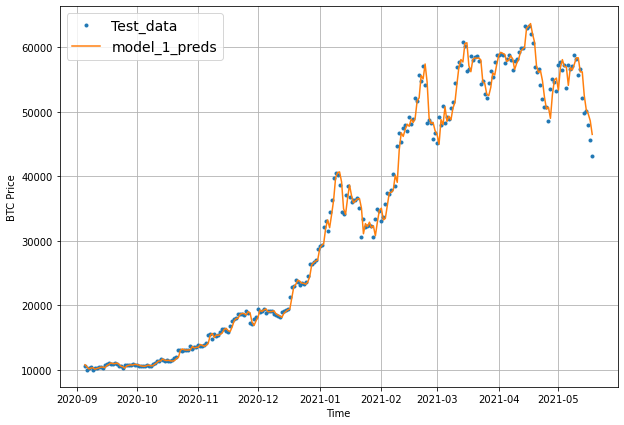

In [42]:
# Visualizing the result

offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

### Model 2: Dense (window = 30, horizon = 1)

In [43]:
HORIZON = 1
WINDOW_SIZE = 30

In [44]:
# Make windowed data with appropriate horizon nad window size

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [45]:
# Make train and test windows

train_windows, test_windows, train_labels, test_labels = make_train_test_split(windows=full_windows,
                                                                               labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [46]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_2_dense")

# Compile model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [47]:
# Evaluate model_2 preds

model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 632.9131


632.9131469726562

In [48]:
# Load in best performing model

model_2 = tf.keras.models.load_model("model_experiments/model_2_dense")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 632.9131


632.9131469726562

In [49]:
# Get forecast predictions

model_2_preds = make_preds(model_2,
                           input_data=test_windows)
model_2_preds[-10:]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([57859.71 , 58544.805, 59040.6  , 57867.973, 57023.598, 53645.57 ,
       51300.1  , 49968.105, 49605.44 , 45666.445], dtype=float32)>

In [50]:
# Evaluate results for model_2 prediction

model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)

In [51]:
model_2_results

{'mae': 632.91315,
 'mse': 1383091.1,
 'rmse': 1176.049,
 'mape': 2.9349866,
 'mase': 1.1063384}

### Model 3: Dense (window = 30, horizon = 7)

In [52]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [53]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [54]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name = "model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [55]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1483.9594


1483.9593505859375

In [56]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 1232.6414


1232.641357421875

In [57]:
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[-5:]

18/18 [==============================] - 0s 4ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[55445.535, 56642.96 , 55886.996, 56832.96 , 55989.598, 56109.434,
        56591.99 ],
       [55476.55 , 56619.36 , 57010.266, 56894.383, 57249.816, 56609.754,
        57379.34 ],
       [58291.93 , 57466.336, 57015.547, 58285.797, 58489.44 , 59446.504,
        58647.66 ],
       [57118.09 , 57404.496, 58541.42 , 58340.92 , 58907.82 , 58298.574,
        60003.99 ],
       [55673.957, 56792.89 , 56959.164, 57265.875, 58091.895, 58219.316,
        58479.76 ]], dtype=float32)>

In [58]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([ 557.0778  ,  404.20773 ,  347.37262 ,  470.07632 ,  446.7264  ,
         578.34357 ,  596.9679  ,  539.2658  ,  501.44705 ,  583.8542  ,
         750.2293  ,  794.97363 ,  811.3043  ,  915.8649  ,  606.54333 ,
         164.72314 ,  210.964   ,  274.46597 ,  308.1633  ,  411.24234 ,
         161.88002 ,  205.60721 ,  218.46785 ,  270.8151  ,  153.3185  ,
          99.38135 ,  123.43736 ,  190.45613 ,  192.81277 ,  183.51912 ,
         287.49295 ,  300.11322 ,  305.9592  ,  268.82016 ,  290.01465 ,
         271.38303 ,  334.6135  ,  229.57785 ,  164.5784  ,  232.98486 ,
         476.13846 ,  195.32658 ,  103.78097 ,  127.64174 ,   96.306015,
         119.77874 ,   90.44134 ,   73.24323 ,   82.447266,  185.91441 ,
         154.48235 ,  166.78746 ,  153.53914 ,  126.60114 ,  253.76932 ,
         354.71283 ,  555.0528  ,  568.92084 ,  577.89465 ,  504.75543 ,
         415.25656 ,  196.5978  ,  215.85359 ,  398.48492 ,  407.50098 ,
         393.3304  ,  454.50174 ,  536.8502 

### Make our evaluation function work for larger horizon

In [59]:
def evaluate_preds(y_true, y_pred):

  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [60]:
# Get model_3 reults

model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1232.6414,
 'mse': 5310878.0,
 'rmse': 1413.7439,
 'mape': 5.552762,
 'mase': 2.1934166}

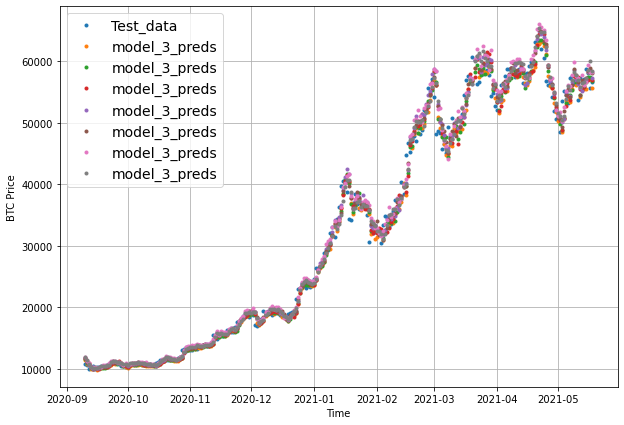

In [61]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

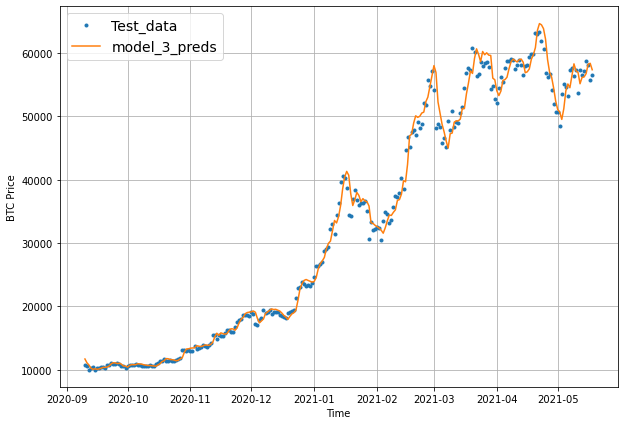

In [62]:
offset = 300
plt.figure(figsize=(10, 7))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), format="-", start=offset, label="model_3_preds")

### Which of our model is performing best so far?

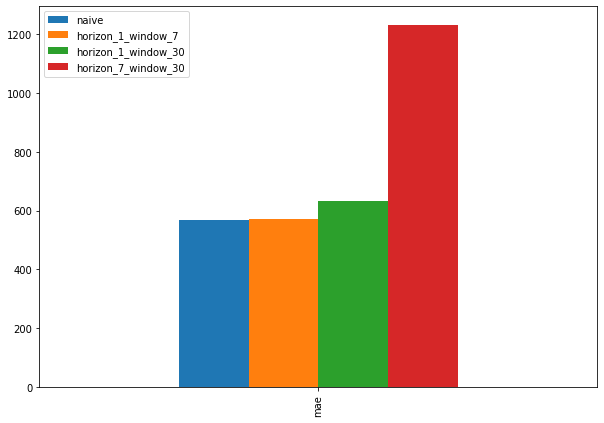

In [63]:
pd.DataFrame({"naive":naive_results["mae"],
              "horizon_1_window_7":model_1_results["mae"],
              "horizon_1_window_30":model_2_results["mae"],
              "horizon_7_window_30":model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

### Model 4: Conv1D

In [64]:
HORIZON = 1
WINDOW_SIZE = 7

In [65]:
# Create windowed dataset

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [66]:
# Create test/train splits

train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [67]:
# Check data sample shapes
train_windows[0].shape

(7,)

In [68]:
# Before we pass our data to conv1D, we have to reshape it to make sure it works

x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))
print(f"Original shape: {x.shape}")
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original values with Expanded shape:\n{expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with Expanded shape:
[[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [69]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    layers.Dense(HORIZON)
], name="model_4_Conv1D")

model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_4.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [70]:
model_4.summary()

Model: "model_4_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [71]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_Conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 6ms/step - loss: 571.7881


571.7880859375

In [72]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:5]

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8908.594, 8803.561, 9003.196, 8807.232, 8763.711], dtype=float32)>

In [73]:
# Evaluate predictions

model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 571.788,
 'mse': 1185819.9,
 'rmse': 1088.9535,
 'mape': 2.573925,
 'mase': 1.0044732}

### Model 5: RNN (LSTM)

In [74]:
tf.random.set_seed(42)

# Let's an LSTM model with the functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# print(x.shape)
# x= layers.LSTM(128, activation="relu", return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
# print(x.shape)
# Add another optional dense layer
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile the model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
18/18 [==============================] - 5s 144ms/step - loss: 2615.3599 - val_loss: 12560.2021
Epoch 2/100
18/18 [==============================] - 2s 117ms/step - loss: 1330.4453 - val_loss: 3226.8491
Epoch 3/100
18/18 [==============================] - 2s 102ms/step - loss: 301.4684 - val_loss: 1175.2505
Epoch 4/100
18/18 [==============================] - 2s 99ms/step - loss: 205.7865 - val_loss: 1023.1624
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 186.9764 - val_loss: 1075.0503
Epoch 6/100
18/18 [==============================] - 2s 113ms/step - loss: 181.7324 - val_loss: 1012.5096
Epoch 7/100
18/18 [==============================] - 0s 8ms/step - loss: 180.6824 - val_loss: 1017.7596
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 178.7864 - val_loss: 1020.5007
Epoch 9/100
18/18 [==============================] - 0s 14ms/step - loss: 177.5429 - val_loss: 1015.8189
Epoch 10/100
18/18 [==============================]

In [75]:
# Load in the best version of model 5 and evaluate

model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 601.2310


601.23095703125